# Q1: Does CCM outperform baselines when A1 and A2 are satisfied?

In [1]:
import sys, os
import tqdm
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms
from IPython.display import Image as showImg
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from copy import deepcopy
import matplotlib
import pandas as pd
from sklearn.metrics import average_precision_score
from torchvision.transforms import GaussianBlur, CenterCrop, ColorJitter, Grayscale, RandomCrop, RandomHorizontalFlip

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.models import MLP
from lib.data import small_CUB, CUB, SubColumn, CUB_test_transform, CUB_train_transform, shortcut_noise_transform
from lib.train import train
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c, bootstrap
from lib.utils import birdfile2class, birdfile2idx, is_test_bird_idx, get_bird_bbox, get_bird_class, get_bird_part, get_part_location, get_multi_part_location, get_bird_name
from lib.utils import get_attribute_name, code2certainty, get_class_attributes, get_image_attributes, describe_bird

In [11]:
# key is dim_noise, value is [clean acc, t=0, t=1]
perf_dict_cbm = {
    0: [72.8, 71.5, 71.6],
    30: [73.1, 71.7, 71.9],
    70: [72.1, 70.5, 70.9],
    # 100: [64.7, 64.1, 64.0], # nonliner (mlp model)
    100: [59.1, 57.7, 57.7] 
}
perf_dict_alpha = { # EYE
    0: [75.2, 73.4, 76.0], # 0.001 -> need to search more upper
    30: [74.9, 74.0, 76.2], # 0.001 (0.01 is 72.8 for biased)
    70: [73.0, 73.4, 76.1], # 0.001 (0.01 is 73.3 for biased)
    100: [69.1, 68.0, 75.9],# 0.01 -> need to search more upper # [64.6, 65.1, 76.2] # 0.001
}
perf_dict_std = { # alpha=0
    0: [69.7, 69.5, 76.0], 
    30: [68.9, 68.7, 76.1],
    70: [67.7, 69.0, 76.4],
    100: [60.4, 62.0, 75.6]
}
perf_dict_ccmr = {
    0: [76.0, 74.9, 75.6],
    30: [76.6, 75.3, 75.9],
    70: [76.4, 74.2, 75.5],
    100: [73.2, 72.3, 75.3], # new model became (71.8, 71.6, 74.8)
}
perf_dict_std_ugrad = { # alpha=0, u_grad=True
    0: [73.5, 72.8, 74.9], 
    30: [73.8, 73.5, 74.8],
    70: [73.5, 74.0, 75.9],
    100: [69.8, 69.6, 75.6]
}

perf_dict_stdx = { # don't change in this setup
    0: [55.8, 55.2, 75.7], 
    100: [55.8, 55.2, 75.7],
}

def select_list(l, *args):
    return [l[a] for a in args]

def report_latex(name, d, fmt='.1f'):
    res = [name]
    for a in d:
        l, h = get_error(a/100.0)
        res.append(f"{a:{fmt}} ({l*100:{fmt}}, {h*100:{fmt}})")

    print(" & ".join(res))

 # bias and clean acc
report_latex('CCM EYE', select_list(perf_dict_alpha[0], 2, 0))
report_latex('CCM RES', select_list(perf_dict_ccmr[0], 2, 0))
report_latex('STD(X)', [75.7, 55.8])
report_latex('CBM', select_list(perf_dict_cbm[0], 2, 0))
report_latex('STD(C,X)', select_list(perf_dict_std[0], 2, 0))

CCM EYE & 76.0 (74.7, 77.0) & 75.2 (74.1, 76.2)
CCM RES & 75.6 (74.5, 76.6) & 76.0 (75.0, 77.1)
STD(X) & 75.7 (74.6, 76.8) & 55.8 (54.7, 57.1)
CBM & 71.6 (70.7, 72.8) & 72.8 (71.7, 73.9)
STD(C,X) & 76.0 (74.9, 77.3) & 69.7 (68.4, 70.8)


# Q2: Does CCM outperform baselines when concepts are incomplete?

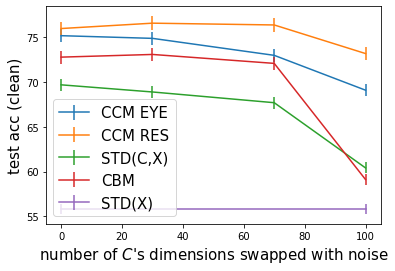

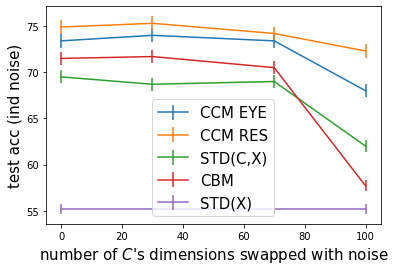

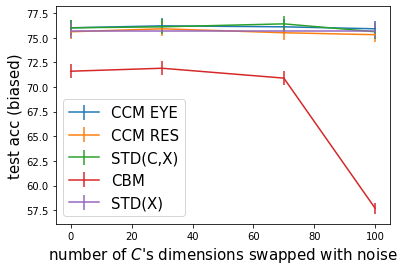

In [12]:
def get_error(p, n=100):
    '''bootstrap'''
    assert 0 <= p <= 1, "probablity is non-negative"
    n_test = 5790 # number of test data in cub
    a, b = np.percentile([sum(np.random.choice(2, n_test, p=[1-p, p])) / float(n_test) for _ in range(n)], [2.5, 97.5])
    return a, b

def plot_d_noise(d, dim=0, label=None):
    x = d.keys()
    y = list(map(lambda x: x[dim], d.values()))
    # plt.plot(x, y, label=label)
    yerr = list(zip(*[get_error(a/100.0) for a in y]))
    plt.errorbar(x, y, yerr=yerr, label=label)

xlabel = "number of $C$'s dimensions swapped with noise"

plot_d_noise(perf_dict_alpha, 0, "CCM EYE")
plot_d_noise(perf_dict_ccmr, 0, "CCM RES")
plot_d_noise(perf_dict_std, 0, "STD(C,X)")
plot_d_noise(perf_dict_cbm, 0, "CBM")
plot_d_noise(perf_dict_stdx, 0, "STD(X)")
# plot_d_noise(perf_dict_std_ugrad, 0, "STD(c,x) with u_grad") # different hyperparam choice
# plt.axhline(55.8, ls='-', color='purple', label='STD(X)')
plt.ylabel('test acc (clean)', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.legend(fontsize=15)
plt.savefig('figures/clean_swap_cub.png')
plt.show()

plot_d_noise(perf_dict_alpha, 1, "CCM EYE")
plot_d_noise(perf_dict_ccmr, 1, "CCM RES")
plot_d_noise(perf_dict_std, 1, "STD(C,X)")
plot_d_noise(perf_dict_cbm, 1, "CBM")
plot_d_noise(perf_dict_stdx, 1, "STD(X)")
# plot_d_noise(perf_dict_std_ugrad, 1, "STD(c,x) with u_grad")
# plt.axhline(57.2, ls='-', color='purple', label='STD(X)')
plt.ylabel('test acc (ind noise)', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.legend(fontsize=15)
plt.savefig('figures/ind_swap_cub.png')
plt.show()

plot_d_noise(perf_dict_alpha, 2, "CCM EYE")
plot_d_noise(perf_dict_ccmr, 2, "CCM RES")
plot_d_noise(perf_dict_std, 2, "STD(C,X)")
plot_d_noise(perf_dict_cbm, 2, "CBM")
plot_d_noise(perf_dict_stdx, 2, "STD(X)")
# plot_d_noise(perf_dict_std_ugrad, 2, "STD(c,x) with u_grad")
# plt.axhline(75.7, ls='-', color='purple', label='STD(X)')
plt.ylabel('test acc (biased)', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.legend(fontsize=15)
plt.savefig('figures/bias_swap_cub.png')
plt.show()